

>Import Required Libraries



In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")


Load the Datasets

In [4]:
orders = pd.read_csv("/orders.csv")
orders.head()


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name
0,1,2508,450,18-02-2023,842.97,New Foods Chinese
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian


In [5]:
users = pd.read_json("/users.json")
users.head()


,user_id,name,city,membership
0,1,User_1,Chennai,Regular
1,2,User_2,Pune,Gold
2,3,User_3,Bangalore,Gold
3,4,User_4,Bangalore,Regular
4,5,User_5,Pune,Gold


In [8]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("/food_delivery.db")

with open("/restaurants.sql", "r", encoding="utf-8") as file:
    sql_script = file.read()

conn.executescript(sql_script)

restaurants = pd.read_sql_query("SELECT * FROM restaurants", conn)
restaurants.head()



,restaurant_id,restaurant_name,cuisine,rating
0,1,Restaurant_1,Chinese,4.8
1,2,Restaurant_2,Indian,4.1
2,3,Restaurant_3,Mexican,4.3
3,4,Restaurant_4,Chinese,4.1
4,5,Restaurant_5,Chinese,4.8


Data Cleaning & Formatting

In [9]:
orders.info()
users.info()
restaurants.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         10000 non-null  int64  
 1   user_id          10000 non-null  int64  
 2   restaurant_id    10000 non-null  int64  
 3   order_date       10000 non-null  object 
 4   total_amount     10000 non-null  float64
 5   restaurant_name  10000 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 468.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     3000 non-null   int64 
 1   name        3000 non-null   object
 2   city        3000 non-null   object
 3   membership  3000 non-null   object
dtypes: int64(1), object(3)
memory usage: 93.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0

In [10]:
orders["order_date"] = pd.to_datetime(orders["order_date"], dayfirst=True)


In [11]:
orders_users = orders.merge(users, how="left", on="user_id")
final_df = orders_users.merge(restaurants, how="left", on="restaurant_id")

final_df.head()


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name_x,name,city,membership,restaurant_name_y,cuisine,rating
0,1,2508,450,2023-02-18,842.97,New Foods Chinese,User_2508,Hyderabad,Regular,Restaurant_450,Mexican,3.2
1,2,2693,309,2023-01-18,546.68,Ruchi Curry House Multicuisine,User_2693,Pune,Regular,Restaurant_309,Indian,4.5
2,3,2084,107,2023-07-15,163.93,Spice Kitchen Punjabi,User_2084,Chennai,Gold,Restaurant_107,Mexican,4.0
3,4,319,224,2023-10-04,1155.97,Darbar Kitchen Non-Veg,User_319,Bangalore,Gold,Restaurant_224,Chinese,4.8
4,5,1064,293,2023-12-25,1321.91,Royal Eatery South Indian,User_1064,Pune,Regular,Restaurant_293,Italian,3.0


In [12]:
final_df.to_csv("final_food_delivery_dataset.csv", index=False)


DATA ANALYSIS SECTION

1. Order Trends Over Time

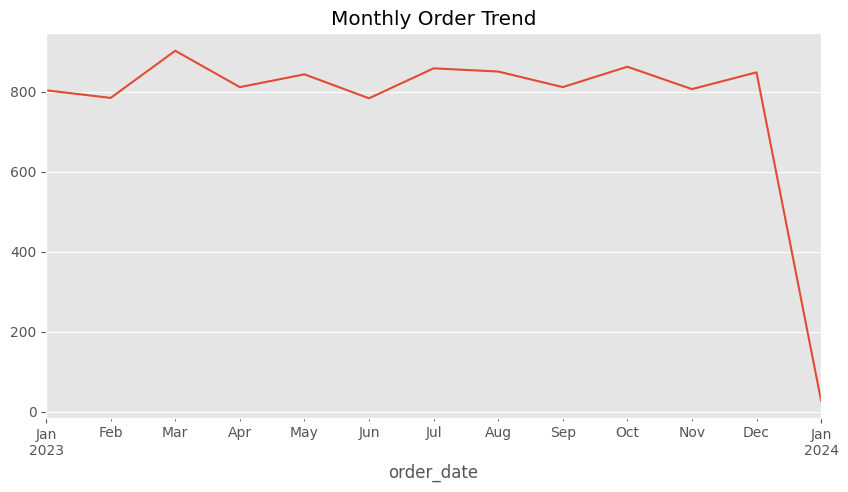

In [13]:
monthly_orders = final_df.groupby(final_df["order_date"].dt.to_period("M"))["order_id"].count()
monthly_orders.plot(figsize=(10,5), title="Monthly Order Trend")
plt.show()


2. City with Highest Revenue from Gold Members

In [14]:
gold_df = final_df[final_df["membership"] == "Gold"]
gold_city_revenue = gold_df.groupby("city")["total_amount"].sum().sort_values(ascending=False)
gold_city_revenue


,total_amount
city,
Chennai,1080909.79
Pune,1003012.32
Bangalore,994702.59
Hyderabad,896740.19


3. Cuisine with Highest Average Order Value

In [15]:
final_df.groupby("cuisine")["total_amount"].mean().sort_values(ascending=False)


,total_amount
cuisine,
Mexican,808.021344
Italian,799.448578
Indian,798.466011
Chinese,798.389020


4. Users Spending More Than ₹1000 in Total

In [16]:
user_spend = final_df.groupby("user_id")["total_amount"].sum()
users_above_1000 = (user_spend > 1000).sum()
users_above_1000


np.int64(2544)

5. Restaurant Rating Range with Highest Revenue

In [17]:
bins = [3.0, 3.5, 4.0, 4.5, 5.0]
labels = ["3.0–3.5", "3.6–4.0", "4.1–4.5", "4.6–5.0"]

final_df["rating_range"] = pd.cut(final_df["rating"], bins=bins, labels=labels)

final_df.groupby("rating_range")["total_amount"].sum().sort_values(ascending=False)


/tmp/ipython-input-3081351284.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df.groupby("rating_range")["total_amount"].sum().sort_values(ascending=False)


,total_amount
rating_range,
4.6–5.0,2197030.75
4.1–4.5,1960326.26
3.0–3.5,1881754.57
3.6–4.0,1717494.41


6. Gold Members – City with Highest Avg Order Value

In [18]:
gold_df.groupby("city")["total_amount"].mean().sort_values(ascending=False)


,total_amount
city,
Chennai,808.459080
Hyderabad,806.421034
Bangalore,793.223756
Pune,781.162243


7. Cuisine with Fewest Restaurants

In [19]:
restaurant_counts = final_df.groupby("cuisine")["restaurant_id"].nunique()
restaurant_counts.sort_values()


,restaurant_id
cuisine,
Chinese,120
Indian,126
Italian,126
Mexican,128


8. Percentage of Orders from Gold Members

In [20]:
gold_percentage = round((len(gold_df) / len(final_df)) * 100)
gold_percentage


50

9. Restaurant with Highest AOV but <20 Orders

In [21]:
rest_stats = final_df.groupby("restaurant_name_x").agg(
    avg_order_value=("total_amount", "mean"),
    order_count=("order_id", "count")
)

rest_stats[rest_stats["order_count"] < 20].sort_values("avg_order_value", ascending=False).head()


,avg_order_value,order_count
restaurant_name_x,,
Hotel Dhaba Multicuisine,1040.222308,13
Sri Mess Punjabi,1029.180833,12
Ruchi Biryani Punjabi,1002.140625,16
Sri Delights Pure Veg,989.467222,18
Classic Kitchen Family Restaurant,973.167895,19


10. Highest Revenue Combination (Membership + Cuisine)

In [22]:
final_df.groupby(["membership", "cuisine"])["total_amount"].sum().sort_values(ascending=False)


membership  cuisine
Regular     Mexican    1072943.30
            Italian    1018424.75
Gold        Mexican    1012559.79
            Italian    1005779.05
Regular     Indian      992100.27
Gold        Indian      979312.31
            Chinese     977713.74
Regular     Chinese     952790.91
Name: total_amount, dtype: float64

11. Revenue by Quarter

In [23]:
final_df["quarter"] = final_df["order_date"].dt.quarter
final_df.groupby("quarter")["total_amount"].sum().sort_values(ascending=False)


,total_amount
quarter,
3,2037385.10
4,2018263.66
1,2010626.64
2,1945348.72


In [26]:
import pandas as pd
final_df = pd.read_csv("final_food_delivery_dataset.csv")
final_df["order_date"] = pd.to_datetime(final_df["order_date"], dayfirst=True)
final_df.head()


/tmp/ipython-input-2385881635.py:6: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  final_df["order_date"] = pd.to_datetime(final_df["order_date"], dayfirst=True)


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name_x,name,city,membership,restaurant_name_y,cuisine,rating
0,1,2508,450,2023-02-18,842.97,New Foods Chinese,User_2508,Hyderabad,Regular,Restaurant_450,Mexican,3.2
1,2,2693,309,2023-01-18,546.68,Ruchi Curry House Multicuisine,User_2693,Pune,Regular,Restaurant_309,Indian,4.5
2,3,2084,107,2023-07-15,163.93,Spice Kitchen Punjabi,User_2084,Chennai,Gold,Restaurant_107,Mexican,4.0
3,4,319,224,2023-10-04,1155.97,Darbar Kitchen Non-Veg,User_319,Bangalore,Gold,Restaurant_224,Chinese,4.8
4,5,1064,293,2023-12-25,1321.91,Royal Eatery South Indian,User_1064,Pune,Regular,Restaurant_293,Italian,3.0


total Orders by Gold Members

In [27]:
gold_orders_count = final_df[final_df["membership"] == "Gold"]["order_id"].count()
gold_orders_count


np.int64(4987)

Total Revenue from Hyderabad (Rounded)



In [28]:
hyderabad_revenue = final_df[final_df["city"] == "Hyderabad"]["total_amount"].sum()
round(hyderabad_revenue)


1889367

Number of Distinct Users Who Placed at Least One Order

In [29]:
distinct_users = final_df["user_id"].nunique()
distinct_users


2883

Average Order Value for Gold Members (2 Decimals)

In [30]:
gold_avg_order_value = final_df[final_df["membership"] == "Gold"]["total_amount"].mean()

round(gold_avg_order_value, 2)


np.float64(797.15)

Orders from Restaurants with Rating ≥ 4.5

In [31]:
high_rating_orders = final_df[final_df["rating"] >= 4.5]["order_id"].count()
high_rating_orders


np.int64(3374)

Orders in the Top Revenue City Among Gold Members

In [32]:
gold_city_revenue = final_df[final_df["membership"] == "Gold"].groupby("city")["total_amount"].sum()

top_gold_city = gold_city_revenue.idxmax()
top_gold_city


'Chennai'

Count Orders in That City (Gold Members Only)

In [33]:
orders_in_top_gold_city = final_df[
    (final_df["membership"] == "Gold") &
    (final_df["city"] == top_gold_city)
]["order_id"].count()

orders_in_top_gold_city


np.int64(1337)